In [1]:
import numpy as np
import pandas as pd
import glob
import os
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.ticker import FormatStrFormatter
from cycler import cycler

import qtl.annotation
import qtl.genotype as gt
import qtl.map
import qtl.plot
import qtl.locusplot

import style

In [2]:
annot = qtl.annotation.Annotation('data/gencode.v26.GRCh38.genes.gtf', verbose=False)
sample_df = pd.read_csv('data/GTEx_Analysis_v8_RNAseq_samples.txt', sep='\t')
sample_s = sample_df[sample_df['has_genotype']].groupby('tissue_id').apply(lambda x: x['sample_id'].tolist())
sample_s = sample_s[sample_s.apply(len)>=70]
size_s = sample_s.apply(len)

### Panel 3A

In [3]:
# load fine-mapping results
caviar_df = pd.read_csv('data/GTEx_v8_finemapping_CAVIAR/CAVIAR_Results_v8_GTEx_LD_ALL_NOCUTOFF_with_Allele.txt.gz',
                        usecols=['TISSUE', 'GENE', 'eQTL', 'Probability'], sep='\t')

caveman_df = pd.read_csv('data/GTEx_v8_finemapping_CaVEMaN/GTEx_v8_finemapping_CaVEMaN.txt.gz',
                         sep='\t', usecols=['TISSUE', 'GENE', 'eQTL', 'Probability'])

dapg_df = pd.read_csv('data/GTEx_v8_finemapping_DAPG/GTEx_v8_finemapping_DAPG.txt.gz',
                      sep='\t', usecols=['tissue_id', 'gene_id', 'variant_id', 'variant_pip'])

In [4]:
egene_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('data/GTEx_Analysis_v8_eQTL/*.v8.egenes.txt.gz')}
tissues = sorted(egene_files)

maxp_dfs = {}
for k,tissue_id in enumerate(tissues, 1):
    print('\rProcessing {}/{}: {}'.format(k, len(tissues), tissue_id), end='')
    # load eGenes
    egenes_df = pd.read_csv(egene_files[tissue_id], sep='\t', index_col=0)
    egenes_df['type'] = egenes_df.index.map(lambda x: annot.gene_dict[x].type)
    egenes_df = egenes_df[egenes_df['type'].isin(['protein_coding', 'lincRNA'])]
    egenes_df = egenes_df[egenes_df['qval']<=0.05]

    # subset by tissue
    caviar_tissue_df = caviar_df[caviar_df['TISSUE']==tissue_id]
    caveman_tissue_df = caveman_df[caveman_df['TISSUE']==tissue_id]
    dapg_tissue_df = dapg_df[dapg_df['tissue_id']==tissue_id]

    caveman_s = caveman_tissue_df.groupby('GENE').apply(lambda x: x['Probability'].max())
    caviar_s = caviar_tissue_df.groupby('GENE').apply(lambda x: x['Probability'].max())
    dapg_s = dapg_tissue_df.groupby('gene_id').apply(lambda x: x['variant_pip'].max())

    # subset for eGenes
    caveman_s = caveman_s[caveman_s.index.isin(egenes_df.index)]
    caviar_s = caviar_s[caviar_s.index.isin(egenes_df.index)]
    dapg_s = dapg_s[dapg_s.index.isin(egenes_df.index)]
    caveman_s.name = 'CaVEMaN'
    caviar_s.name = 'CAVIAR'
    dapg_s.name = 'dap-g'
    maxp_dfs[tissue_id] = pd.concat([caveman_s, caviar_s, dapg_s, egenes_df['log2_aFC']], axis=1, sort=False)

Processing 49/49: Whole_Bloodtine_Terminal_Ileumctionia

In [5]:
ix = ['PPC > 0.5 & aFC > 1', 'PPC > 0.5 & aFC ≤ 1', 
      'PPC ≤ 0.5 & aFC > 1', 'PPC ≤ 0.5 & aFC ≤ 1',
      'PPC ≤ 0.5', 'aFC > 1', 'aFC ≤ 1']

caveman_summary_df = []
caviar_summary_df = []
dapg_summary_df = []
aFC_threshold = np.log2(2)
for tissue_id in sorted(maxp_dfs):
    df = maxp_dfs[tissue_id]

    caveman_summary_df.append(pd.Series([
        np.sum((df['CaVEMaN'] >  0.5) & (df['log2_aFC'].abs() >  aFC_threshold)), 
        np.sum((df['CaVEMaN'] >  0.5) & (df['log2_aFC'].abs() <= aFC_threshold)),
        np.sum((df['CaVEMaN'] <= 0.5) & (df['log2_aFC'].abs() >  aFC_threshold)), 
        np.sum((df['CaVEMaN'] <= 0.5) & (df['log2_aFC'].abs() <= aFC_threshold)),
        np.sum((df['CaVEMaN'] <= 0.5) | df['CaVEMaN'].isnull()),
        np.sum(df['log2_aFC'].abs() >  aFC_threshold), 
        np.sum(df['log2_aFC'].abs() <= aFC_threshold),
    ], index=ix, name=tissue_id))

    caviar_summary_df.append(pd.Series([
        np.sum((df['CAVIAR'] >  0.5) & (df['log2_aFC'].abs() >  aFC_threshold)), 
        np.sum((df['CAVIAR'] >  0.5) & (df['log2_aFC'].abs() <= aFC_threshold)), 
        np.sum((df['CAVIAR'] <= 0.5) & (df['log2_aFC'].abs() >  aFC_threshold)), 
        np.sum((df['CAVIAR'] <= 0.5) & (df['log2_aFC'].abs() <= aFC_threshold)), 
        np.sum((df['CAVIAR'] <= 0.5) | df['CAVIAR'].isnull()),
        np.sum(df['log2_aFC'].abs() >  aFC_threshold), 
        np.sum(df['log2_aFC'].abs() <= aFC_threshold),
    ], index=ix, name=tissue_id))

    dapg_summary_df.append(pd.Series([
        np.sum((df['dap-g'] >  0.5) & (df['log2_aFC'].abs() >  aFC_threshold)), 
        np.sum((df['dap-g'] >  0.5) & (df['log2_aFC'].abs() <= aFC_threshold)),
        np.sum((df['dap-g'] <= 0.5) & (df['log2_aFC'].abs() >  aFC_threshold)), 
        np.sum((df['dap-g'] <= 0.5) & (df['log2_aFC'].abs() <= aFC_threshold)),
        np.sum((df['dap-g'] <= 0.5) | df['dap-g'].isnull()),
        np.sum(df['log2_aFC'].abs() >  aFC_threshold), 
        np.sum(df['log2_aFC'].abs() <= aFC_threshold),
    ], index=ix, name=tissue_id))

ix = [i for i in size_s.sort_values().index]
caveman_summary_df = pd.DataFrame(caveman_summary_df).loc[ix]
caviar_summary_df = pd.DataFrame(caviar_summary_df).loc[ix]
dapg_summary_df = pd.DataFrame(dapg_summary_df).loc[ix]

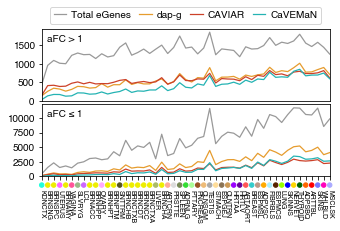

In [6]:
# plot
dt = 0.5
ah = 1
aw = 4
ds = 0.05
db = 0.75
dl = 0.75
dr = 0.5
fw = dl + aw + dr
fh = db + 2*ah + ds + dt
fig = plt.figure(facecolor=(1,1,1), figsize=(fw,fh))
ax1 = fig.add_axes([dl/fw, (db+ah+ds)/fh, aw/fw, ah/fh])
ax2 = fig.add_axes([dl/fw, db/fh, aw/fw, ah/fh], sharex=ax1)

args = {'lw':1.25, 'linestyle':'-'}
c = [0.6]*3+[1]
ax2.plot(dapg_summary_df['aFC ≤ 1'], '-',  color=c, **args)
ax2.plot(dapg_summary_df['PPC > 0.5 & aFC ≤ 1'], color=style.finemap_color_s['dap-g'], **args)
ax2.plot(caviar_summary_df['PPC > 0.5 & aFC ≤ 1'], color=style.finemap_color_s['caviar'], **args)
ax2.plot(caveman_summary_df['PPC > 0.5 & aFC ≤ 1'], color=style.finemap_color_s['caveman'], **args)
ax1.plot(dapg_summary_df['aFC > 1'], '-', color=c, label='Total eGenes', **args)
ax1.plot(dapg_summary_df['PPC > 0.5 & aFC > 1'], color=style.finemap_color_s['dap-g'], label='dap-g', **args)
ax1.plot(caviar_summary_df['PPC > 0.5 & aFC > 1'], color=style.finemap_color_s['caviar'], label='CAVIAR', **args)
ax1.plot(caveman_summary_df['PPC > 0.5 & aFC > 1'], color=style.finemap_color_s['caveman'], label='CaVEMaN', **args)

ax2.set_xlim([0,48])
ax2.set_xticks(np.arange(len(ix)))
ax2.set_xticklabels(style.colors_df.loc[ix, 'tissue_abbrv'], rotation=-90, ha='center', fontsize=6);
ax1.text(0.02,0.925, 'aFC > 1', ha='left', va='top', transform=ax1.transAxes)
ax2.text(0.02,0.925, 'aFC ≤ 1', ha='left', va='top', transform=ax2.transAxes)
ax2.tick_params(axis='x', which='major', pad=10, labelsize=7)

# add sample size dots
ax1.set_ylim([0, ax1.get_ylim()[1]])
ax2.set_ylim([0, ax2.get_ylim()[1]])
ylim = ax2.get_ylim()
s = 1 + (.06 * 2/ah)
b = ylim[1] - s*np.diff(ylim)
ax2.set_ylim(ylim)
ax2.scatter(np.arange(len(ix)), b*np.ones(len(ix)),
           s=20,
           c=style.colors_df.loc[ix, 'color_hex'], clip_on=False)

ax1.legend(loc='lower center', ncol=4, columnspacing=0.8,
           handlelength=1.25, handletextpad=0.5, borderaxespad=None, labelspacing=0.25,
           bbox_to_anchor=(0.5,1))

ax1.set_yticks(np.arange(0,2000,500))
ax2.set_yticks(np.arange(0,12000,2500))

plt.setp(ax1.get_xticklabels(), visible=False);
for line in ax1.xaxis.get_ticklines():
    line.set_markersize(0) # tick length
    line.set_markeredgewidth(0) # tick line width

ax2.tick_params(axis='x', which='major', pad=10, labelsize=7)
plt.savefig('pdfs/Fig3A_fine_mapping_summary.pdf')

### Panel 3B

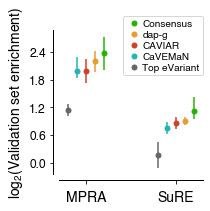

In [7]:
validation_df = pd.read_csv('data/Fig3B_finemapping_exp_validation_data.txt', sep='\t')

args = {'fmt':'.', 'ms':10, 'lw':1.5, 'clip_on':False}
custom_cycler = cycler('color', style.finemap_color_s)
method = ["Top eVariant", "CaVEMaN", "CAVIAR", "dap-g", "Consensus"]
experiment = ["MPRA", "SuRE"]

ax = qtl.plot.setup_figure(2,2, xspace=[1,0.25], yspace=[0.75, 0.5])
ax.set_prop_cycle(custom_cycler)
x = np.array([0,1])
s = 0.1
d = (len(method)-1)/2*s
for k,m in enumerate(method):
    idf = validation_df[validation_df['method']==m]
    ax.errorbar(x+s*k-d, idf['estimate'], idf[['ci_low', 'ci_high']].values.T, 
                label=m, **args)

qtl.plot.format_plot(ax, fontsize=12)
ax.spines['bottom'].set_position(('outward', 6))
ax.spines['left'].set_position(('outward', 6))

ax.yaxis.set_major_locator(ticker.MaxNLocator(min_n_ticks=5, nbins=5))
ax.set_xticks(x)
ax.set_xticklabels(experiment, fontsize=14)
ax.tick_params(axis='x', which='major', pad=6, labelsize=14)

ax.set_xlim([-d-s, len(x)-1+d+s])

ax.set_ylabel('Enrichment among experimentally\nvalidated regulatory variants', fontsize=14)
ax.set_ylabel('log$\mathregular{_2}$(Validation set enrichment)', fontsize=14)
    
ax.legend(loc='upper right')
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles[::-1], labels[::-1], loc='upper right', ncol=1, numpoints=1, 
          handletextpad=0.1, borderpad=0.33, handlelength=1.5,
          labelspacing=0.2, borderaxespad=0, bbox_to_anchor=(1.0,1.1))

plt.savefig('pdfs/Fig3B_fine_mapping_exp_enrichment.pdf')

### Panel 3C

Getting GT for region chr17:79701683-79901683


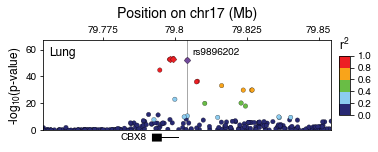

In [8]:
tissue_id = 'Lung'
gene = annot.get_gene('CBX8')
gene_id = gene.id
chrom = gene.chr

variant_id = 'chr17_79804428_T_C_b38'
rs_id = 'rs9896202'

phenotype_bed = 'data/GTEx_Analysis_v8_eQTL_expression_matrices/{}.v8.normalized_expression.bed.gz'.format(tissue_id)
phenotype_df = pd.read_csv(phenotype_bed, sep='\t', index_col=3).drop(['#chr', 'start', 'end'], axis=1)
phenotype_s = phenotype_df.loc[gene_id]

vcf = 'data/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.vcf.gz'
genotype_df = gt.get_cis_genotypes(gene.chr, gene.tss, vcf, window=100000)[phenotype_df.columns]
gt.impute_mean(genotype_df, verbose=False)
r2_s = qtl.locusplot.compute_ld(genotype_df, variant_id)

covariates_df = pd.read_csv('data/GTEx_Analysis_v8_eQTL_covariates/{}.v8.covariates.txt'.format(tissue_id), sep='\t', index_col=0).T

eqtl_df = qtl.map.calculate_association(genotype_df, phenotype_s, covariates_df)

highlight_ids = ['chr17_79798269_G_A_b38', 'chr17_79799519_T_C_b38']
ax = qtl.locusplot.plot_locus([eqtl_df], gene_id, variant_id, annot, r2_s=r2_s, labels=['Lung'],
                               rs_id=rs_id, highlight_ids=highlight_ids, shade_range=[79804378, 79804478], 
                               gene_label_pos='left', chr_label_pos='top', window=50000)

plt.savefig('pdfs/Fig3C_fine_mapping_CBX8_locus.pdf')

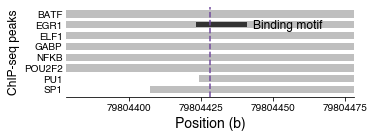

In [9]:
tf_df = pd.read_csv('data/Fig3C_CDX8.mainsnp.region.bothtfs.txt', sep='\t')
motif_s = tf_df[tf_df['type']=='motif'].iloc[0]
tf_df = tf_df[tf_df['type']=='peak']
tf_df.drop(5, inplace=True)
tf_df = tf_df.sort_values('tf_factor')

ax = qtl.plot.setup_figure(4, 1.25, xspace=[1, 0.75], yspace=[0.5, 0.25])
h = 0.66
for _,r in tf_df.iterrows():
    d = r['stop'] - r['start'] + 1
    ax.add_patch(patches.Rectangle((r['start'], r['tf_factor']-1-h/2), d, h, facecolor=[0.75]*3, zorder=-10))

r = motif_s
d = r['stop'] - r['start'] + 1
ax.add_patch(patches.Rectangle((r['start'], r['tf_factor']-1-h/2*0.66), d, h*0.66, facecolor=[0.2]*3, zorder=-10))
ax.text(r['stop']+3, r['tf_factor']-0.5, 'Binding motif', color='k', va='top', fontsize=12)
ax.set_yticks(np.arange(tf_df.shape[0]))
ax.set_yticklabels(tf_df['tf'])
ylim = [-1+h/2, tf_df.shape[0]-h/2]

ax.plot([79804428, 79804428], ylim, '--', c="#714A9D")
ax.set_ylim(ylim)
b = 0
ax.set_xlim([tf_df['start'].min()-b, tf_df['stop'].max()+b])
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

if 0:
    ax.xaxis.tick_top()
    ax.spines['bottom'].set_visible(False)
else:
    ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='both', direction='out', labelsize=10, length=0)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlabel('Position (b)', fontsize=14)
ax.set_ylabel('ChIP-seq peaks', fontsize=12)

plt.savefig('pdfs/Fig3C_fine_mapping_CBX8_locus_TFs.pdf')

### Panel 3D

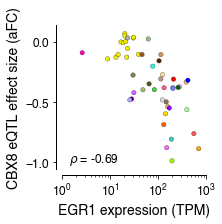

In [10]:
gene_name = 'EGR1'
gene_id = annot.get_gene(gene_name).id
variant_id = 'chr17_79804428_T_C_b38'

afc_df = pd.read_csv('data/Fig3D_CDX8.aFC_EGR1expr.txt', sep='\t').set_index('TISSUE_NAME')

ax = qtl.plot.setup_figure(2,2, xspace=[1,0.25], yspace=[0.75, 0.5])
ax.set_xscale('log')
ax.scatter(afc_df['tf_expr'], afc_df['afc'], 
           s=20, c=style.colors_df.loc[afc_df.index, 'color_hex'],
          edgecolor='k', lw=0.25)

qtl.plot.format_plot(ax, fontsize=12)
ax.set_xlabel('EGR1 expression (TPM)', fontsize=14)  # median across tissues
ax.set_ylabel('CBX8 eQTL effect size (aFC)', fontsize=14)

rho = stats.spearmanr(afc_df['tf_expr'], afc_df['afc'])[0]
ax.text(0.05,0.05, r'$\rho$ = {:.2f}'.format(rho), fontsize=12, transform=ax.transAxes)

ax.set_xlim([1, 1000])
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.set_yticks(np.arange(-1,0.5,0.5))
ax.spines['bottom'].set_position(('outward', 6))
ax.spines['left'].set_position(('outward', 6))

plt.savefig('pdfs/Fig3D_fine_mapping_EGR1_vs_aFC.pdf')